# Credit Analytics - Final Project Code
By: Dennis Goldenberg, Triet Vo, Kezia 

In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, binom

## 1. Comparing Binomial Expansion Model to Gaussian Copula Model

Taking average 10-year cumulative default probabilities from the insurance industry (1981-2021) based on S&P Ratings data, I can generate estimates for the homogeneous, correlated portfolio:

In [367]:
num_assets = 100
Notional = 10000000

#Generate random Notional amounts
np.random.seed(4)
Notionals = np.random.uniform(low = .25 * Notional/num_assets, high = 1.75 * Notional/num_assets, size = num_assets)


#recover number of names given defaults from 15 year data
N_i = np.asarray([int(21/.173),int(15/.028),int(8/.1029), int(16/.1409)])

#Generate default probabilities - 250 names rated BBB, BB, B, and C, 10 years into maturity
rd_probs = np.asarray([.0131, .0243, .0811, .1105])
D_i = np.asarray([int(N_i[i] * rd_probs[i]) for i in range(len(N_i))]) + 1

default_probs = [rd_probs[0]] * int(num_assets/4) + [rd_probs[1]]*int(num_assets/4)
default_probs = default_probs + [rd_probs[1]]*int(num_assets/4) + [rd_probs[3]]*int(num_assets/4)
default_probs = np.asarray(default_probs)

#calculate joint probabilities and default correlation
joint_prob = np.empty(shape = (4,4))
corr_mat = np.empty(shape = (4,4))
for i in range(len(N_i)):
    for j in range(len(N_i)):
        if i == j:
            joint_prob[i,j] = (D_i[i]**2)/(N_i[i]**2)
            corr_mat[i,j] = (joint_prob[i,j] - (rd_probs[i]**2))/(rd_probs[i]*(1 - rd_probs[i]))
        else:
            joint_prob[i,j] = (D_i[i] * D_i[j])/(N_i[i]*N_i[j])
            corr_mat[i,j] = (joint_prob[i,j] - (rd_probs[i]*rd_probs[j]))
            corr_mat[i,j] = corr_mat[i,j]/np.sqrt(rd_probs[i]*(1 - rd_probs[i]) * rd_probs[j]*(1 - rd_probs[j]))

The joint probability of defaults is shown below:

In [383]:
ratings = ["A", "BBB", "BB", "B"]
jp_df = pd.DataFrame(data = joint_prob, columns = ratings, index = ratings)
jp_df

,A,BBB,BB,B
A,0.000273,0.000433,0.001503,0.001902
BBB,0.000433,0.000685,0.002379,0.003011
BB,0.001503,0.002379,0.008264,0.010459
B,0.001902,0.003011,0.010459,0.013235


Next, the default correlation between two names, depending on their rating, is shown below:

In [384]:
rho_df = pd.DataFrame(data = corr_mat, columns = ratings, index = ratings)
rho_df

,A,BBB,BB,B
A,0.007858,0.006523,0.014182,0.012736
BBB,0.006523,0.003977,0.009711,0.006740
BB,0.014182,0.009711,0.022641,0.017492
B,0.012736,0.006740,0.017492,0.010428


I calculate the estimate of the average correlation by calculating the paired correlation matrix and then using the formula:

In [385]:
# calculated the paired correlation matrix
paired_corr = np.empty(shape = (num_assets, num_assets))
for k in range(num_assets):
    if k < int(num_assets/4):
        arr = [rho_df["A"]["A"]]*int(num_assets/4) + [rho_df["A"]["BBB"]]*int(num_assets/4)
        arr = arr + [rho_df["A"]["BB"]]*int(num_assets/4) + [rho_df["A"]["B"]]*int(num_assets/4)
        paired_corr[k] = arr
    elif k < int(num_assets/2):
        arr = [rho_df["BBB"]["A"]]*int(num_assets/4) + [rho_df["BBB"]["BBB"]]*int(num_assets/4)
        arr = arr + [rho_df["BBB"]["BB"]]*int(num_assets/4) + [rho_df["BBB"]["B"]]*int(num_assets/4)
        paired_corr[k] = arr
    elif k < int(3 * num_assets / 4):
        arr = [rho_df["BB"]["A"]]*int(num_assets/4) + [rho_df["BB"]["BBB"]]*int(num_assets/4)
        arr = arr + [rho_df["BB"]["BB"]]*int(num_assets/4) + [rho_df["BB"]["B"]]*int(num_assets/4)
        paired_corr[k] = arr
    else:
        arr = [rho_df["B"]["A"]]*int(num_assets/4) + [rho_df["B"]["BBB"]]*int(num_assets/4)
        arr = arr + [rho_df["B"]["BB"]]*int(num_assets/4) + [rho_df["B"]["B"]]*int(num_assets/4)
        paired_corr[k] = arr
    paired_corr[k,k] = 1

#generate all combinations of notionals and probability amounts
Not_mult = np.matmul(np.expand_dims(Notionals, axis = 1),np.expand_dims(Notionals, axis = 0))
def_mult = np.matmul(np.expand_dims(default_probs, axis = 1), np.expand_dims(default_probs, axis = 0))

#Sum upper triangular and lower triangular elements for estimate:
rho_est_num = np.sum(np.triu(paired_corr * Not_mult * def_mult)) - np.sum(np.diag(paired_corr * Not_mult * def_mult))
rho_est_denom = np.sum(np.triu(Not_mult * def_mult)) - np.sum(np.diag(Not_mult * def_mult))
rho_est = rho_est_num/rho_est_denom
print("Estimate of correlation:", np.round(rho_est, 5) * 100, "%")

Estimate of correlation: 1.15 %


Then, I estimate the correlated diversity score $D_\rho$ with the formula provided in the article:

In [386]:
AB = np.sum(Notionals)/num_assets
EUS = [np.min([Notionals[i]/AB, 1]) for i in range(len(Notionals))]
D_indep = np.sum(EUS)
D_rho = ((1 - rho_est)* D_indep)/(1 - (rho_est * D_indep))
D_indep = int(round(D_indep,0))
D_rho = int(round(D_rho,0))
print("Independent Diversity Score:", D_indep, "Correlated Diversity Score:", D_rho)

Independent Diversity Score: 83 Correlated Diversity Score: 2045


I generate the loss distribuions with the independent binomial expansion technique:

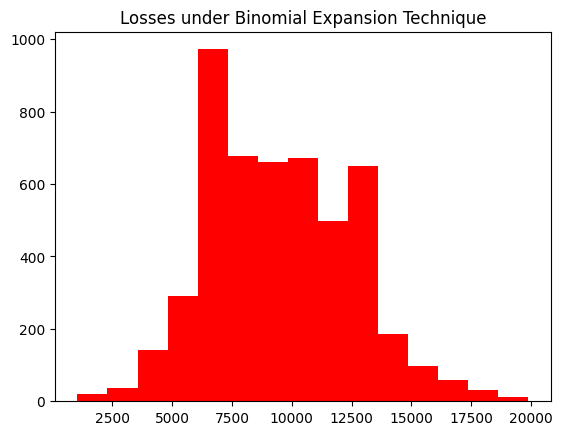

In [462]:
#Assume weighted probability of default higher than average marginal
p = rd_probs[3]
recovery = .3
np.random.seed(4)
defaults = np.random.binomial(D_indep, p, size = 5000)
fv = np.sum(Notionals)/D_indep
loss = defaults * fv * (1 - recovery)
loss_pct = loss/D_indep
plt.hist(loss_pct, bins = 15, color = 'red')
plt.title("Losses under Binomial Expansion Technique")
plt.show()

In [463]:
losses_equity = [np.max([0, ((l/D_indep)* (1 - recovery))/(.1)]) for l in range(D_indep + 1)]
losses_mezz_1 = [np.max([0, ((l/D_indep)* (1 - recovery) - .1)/(.25 - .1)]) for l in range(D_indep + 1)]
losses_mezz_2 = [np.max([0, ((l/D_indep)* (1 - recovery) - .25)/(.4 - .25)]) for l in range(D_indep + 1)]
losses_senior = [np.max([0, ((l/D_indep)* (1 - recovery) - .4)/(1 - .4)]) for l in range(D_indep + 1)]
E_L_equity = np.sum([losses_equity[l] * binom.pmf(l,D_indep, p) for l in range(D_indep + 1)])
E_L_mezz_1 = np.sum([losses_mezz_1[l] * binom.pmf(l,D_indep, p) for l in range(D_indep + 1)])
E_L_mezz_2 = np.sum([losses_mezz_2[l] * binom.pmf(l,D_indep, p) for l in range(D_indep + 1)])
E_L_senior = np.sum([losses_senior[l] * binom.pmf(l,D_indep, p) for l in range(D_indep + 1)])
E_L = np.round(np.asarray([E_L_equity, E_L_mezz_1, E_L_mezz_2, E_L_senior]),4)

In [465]:
E_d = p
std_d = np.sqrt(p * (1 - p))
print("Expected Default %:", round(E_d * 100,4))
print("Standard deviation of default %:", round(std_d * 100,4))
print("Expected Loss percentage by tranche:")
print(E_L)
credit_ratings = ["N/A", "Baa1", "Aaa", "Aaa"]
print(credit_ratings)

Expected Default %: 11.05
Standard deviation of default %: 31.3512
Expected Loss percentage by tranche:
[0.7735 0.0166 0.     0.    ]
['N/A', 'Baa1', 'Aaa', 'Aaa']


In [372]:
#surv_probs = 1 - default_probs
#surv_mult = np.matmul(np.expand_dims(surv_probs, axis = 1), np.expand_dims(surv_probs, axis = 0))
#D_est_num = np.sum(default_probs * Notionals)*np.sum(surv_mult * Notionals)*(1 - rho_est)
#D_denom_1 = np.sum(paired_corr * np.sqrt(def_mult * surv_mult) * Not_mult)
#D_denom_2 = rho_est * np.sum(default_probs * Notionals) * np.sum(surv_probs * Notionals)
#D_rho_est = (D_est_num)/(D_denom_1 - D_denom_2)

10875.70116160647

## 2. Comparing Gaussian Copula to Fudged Period by Period Copula